In [1]:
# lookup index in sorted values
import bisect
import pathlib

# io
import netCDF4
# siggyf/pyugrid#develop branch (waiting to be merged into pyugrid pr#144)
import pyugrid
import rasterio
import rasterio.plot
import rasterio.windows

# computing
import numpy as np
import shapely.geometry
import pandas

# notebook extensions
from ipywidgets import interact, interactive, fixed
import tqdm

# plotting
import cmocean.cm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.style
# matplotlib.style.use('ggplot')

import flowmap.subgrid
import flowmap.formats
import flowmap.dem

%matplotlib inline

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# tiff file that has a correction for the 1d bathymetry (deburned channels) 
# original bathymetry with burned streams is named 'dem_3Di_2272015.tif'
dem_filename = pathlib.Path('~/data/rijnland/Groesbeek/aw_ahn_d_asc.tiff').expanduser()

fm_filename = pathlib.Path('~/data/rijnland/Groesbeek/groesbeek_map.nc').expanduser()

t = -1

This notebook gives an example of how to apply a subgrid technique to an arbitrary numerical model result. 
A flow field is computed using a course schematization. In this example the coarse model computes on a 8m x 8m resolution. The dem is available at 0.5m resolution. So the question is, how do we take into account the high resolution dem after the model has already determined the volumes and fluxes in the coarse grid cells. 

We take the approach of redistrbuting the volumes by filling up the detailed bathymetry from the bottom.
Other approaches are to fill the bathymetry using an interpolated function or from the cell edge with the largest volume difference. 

Advantages of this method over other methods:
- Only computed for flooded areas
- Can be applied a posteriori. No need to implement subgridding in the model.
- Flexibility in detail (only compute on visualization)


Dem
====
Read the high detailed dem file

In [3]:

dem = flowmap.dem.read_dem(dem_filename)


Model
=====

Read the model output

In [4]:
ugrid = flowmap.formats.UGrid(fm_filename)

Example
======

In [5]:
# read the dem

data = ugrid.waterlevel(-1)

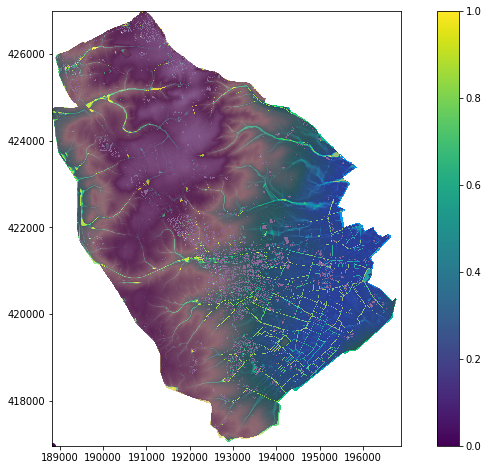

In [6]:
# range (vmin, vmax) of waterdepth 
domain = data['waterdepth'].min(), data['waterdepth'].max()
domain = 0, 1
N = matplotlib.colors.Normalize(*domain)
colors = matplotlib.cm.viridis(N(data['waterdepth']))
colors[data['waterdepth'] < 0.03, 3] = 0.1
colors[:, 3] = 0.6

polys = matplotlib.collections.PolyCollection(verts=ugrid.ugrid['face_coordinates'], facecolors=colors, edgecolors='none')
fig, ax = plt.subplots(figsize=(13, 8))
sc = ax.scatter([dem['extent'][0]], [dem['extent'][2]], c=[0], vmin=domain[0], vmax=domain[1], cmap='viridis')

ax.imshow(
    dem['band'][::10,::10], 
    cmap=matplotlib.cm.terrain, 
    vmin=0, 
    vmax=100,
    extent=dem['extent']
)
ax.add_collection(polys)
ax.autoscale()
for i, xy in enumerate(ugrid.ugrid['face_centers']):
    if i < 0:
        ax.text(xy[0], xy[1], str(i), fontsize=8)
plt.colorbar(sc, ax=ax)

 Compute volume relocation
 
 Cell volume -> pixel cumalitive volume (over threshold)
 cell 4701

In [8]:
values = np.c_[data['s1'], data['vol1'], data['waterdepth']]
L = flowmap.subgrid.build_interpolate(ugrid.ugrid, values)

In [9]:
@interactive
def plot(x=(1000,dem['width'], 1000), y=(1000, dem['width'], 1000)):
    # row columns
    s = np.s_[(y-500):(y+500), (x-500):(x+500)]
    
    interpolated = flowmap.subgrid.compute_interpolated(L, dem, data, s=s)
    masked_waterdepth = interpolated['masked_waterdepth']
    s1 = interpolated['s1']    
    vol1 = interpolated['vol1']
    dem_band = interpolated['dem']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    im = axes[0, 0].imshow(s1 - dem_band, cmap='Blues')
    plt.colorbar(im, ax=axes[0, 0])
    axes[0, 0].set_title('s1 - dem')
    im = axes[0, 1].imshow(s1, cmap='viridis')
    plt.colorbar(im, ax=axes[0, 1])
    axes[0, 1].set_title('s1')
    im = axes[0, 2].imshow(dem_band, cmap='viridis')
    plt.colorbar(im, ax=axes[0, 2])
    axes[0, 2].set_title('dem')
    im = axes[1, 0].imshow(vol1, cmap='viridis', vmax=20)
    plt.colorbar(im, ax=axes[1, 0])
    axes[1, 0].set_title('vol1')
    
    im = axes[1, 1].imshow(masked_waterdepth, cmap='Blues', vmax=0.3)
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_title('waterdepth (interpolated and masked)')
    axes[1, 2].axis('off')
plot

interactive(children=(IntSlider(value=8000, description='x', max=16096, min=1000, step=1000), IntSlider(value=8000, description='y', max=16096, min=1000, step=1000), Output()), _dom_classes=('widget-interact',))